<a href="https://colab.research.google.com/github/iShreyanshKumar/Codeweek_ML/blob/main/Codeweek_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Tool Setup

In [1]:
!pip install langchain_google_genai google_generativeai
!pip install -U langchain-google-vertexai
!pip install -U langgraph langchain
!pip install -U langgraph langsmith

from typing import Annotated

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.tools import Tool

!pip install langchain_tavily
from langchain_tavily import TavilySearch

from langgraph.checkpoint.memory import MemorySaver

import os

!pip install langgraph-supervisor
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

from langchain_google_genai import ChatGoogleGenerativeAI
os.environ["GOOGLE_API_KEY"]=""
os.environ["TAVILY_API_KEY"] = ""
WEATHER_API_KEY=""

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17"
)

# Level 1
Objective
 - Construct a LangGraph node called chatbot, powered by an LLM (Gemini preferred, though
any open-source model may be used)
 - Integrate a companion tool: the calculator, capable of performing basic arithmetic and
supports basic BODMAS rule.
 - Visualize the awakening: Once your LangGraph is wired, render the graph as an image. We
want to see the neural pathways—the AI's skeleton—coming to life

In [2]:
# from langgraph.prebuilt import create_react_agent
# from langgraph.checkpoint.memory import InMemorySaver

In [3]:
# checkpointer = InMemorySaver()
# from pydantic import BaseModel


In [4]:
# def maths(exp: str) -> int:
#     """Evaluate the expression."""
#     return eval(exp)

# class MathResponse(BaseModel):
#     conditions: str

# agent = create_react_agent(
#     model=llm,
#     tools=[maths],
#     prompt="Solve the mathematical expression by passing the numeric part to tool using BODMAS",
#     checkpointer=checkpointer,
#     response_format=MathResponse
# )

# # Run the agent
# config = {"configurable": {"thread_id": "1"}}
# sf_response = agent.invoke(
#     {"messages": [{"role": "user", "content": "calculate 3*5"}]},
#     config
# )
# # ny_response = agent.invoke(
# #     {"messages": [{"role": "user", "content": "calculate 2*5"}]},
# #     config
# # )

In [5]:
# sf_response["structured_response"]

The above code returned the conditions instead of result so I modified it little bit and changed the static prompt also and now it works

In [6]:
# def maths(exp: str) -> int:
#     """Evaluate the expression."""
#     return eval(exp)

# class MathResponse(BaseModel):
#     result: float

# agent = create_react_agent(
#     model=llm,
#     tools=[maths],
#     prompt="Identify the numeric expression and solve it using the `maths` tool following BODMAS. Return only the final result as `result`.",
#     checkpointer=checkpointer,
#     response_format=MathResponse
# )

# # Run the agent
# config = {"configurable": {"thread_id": "1"}}
# response = agent.invoke(
#     {"messages": [{"role": "user", "content": "calculate 3*5"}]},
#     config
# )

In [7]:
# response["structured_response"]

####Ok the above thing was not asked in the task so now I will build the required chatbot and construct its graph.

In [8]:
def calculator_func(input_str):
      result = eval(input_str)
      return f"Result: {result}"

In [9]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = Tool(
    name="calculator_tool",
    func=calculator_func,
    description="Use this tool to perform basic arithmetic calculations. The input should be a valid mathematical expression.",
)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

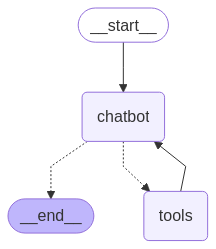

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
      user_input = input("User: ")
      if user_input.lower() in ["quit", "exit", "q"]:
          print("Goodbye!")
          break
      stream_graph_updates(user_input)

User: what is 8*9-5
Assistant: 
Assistant: Result: 67
Assistant: 8*9-5 = 67
User: calculate 69*96
Assistant: 
Assistant: Result: 6624
Assistant: 69 multiplied by 96 is 6624.
User: q
Goodbye!


#Level 2
Objectives
- Fashion Recommender Tool: Given a query like “What’s trending in Tokyo?”, it should parse
the location and surface real-time fashion trends
- Weather Extractor Tool: Using a weather API, this tool must fetch and return current
weather conditions based on the input query

In [12]:
import requests

def get_weather(city: str) -> str:
    """
    Fetch current weather data for a given city using OpenWeatherMap API.
    """
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={WEATHER_API_KEY}&units=metric"

    response = requests.get(url)

    data = response.json()
    description = data["weather"][0]["description"]
    temperature = data["main"]["temp"]
    return f"The current weather in {city} is {description} with a temperature of {temperature}°C."

def calculator_func(input_str):
    result = eval(input_str)
    return f"Result: {result}"


In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

calc_tool = Tool(
    name="calculator_tool",
    func=calculator_func,
    description="Use this tool to perform basic arithmetic calculations. The input should be a valid mathematical expression.",
)

weather_tool = Tool(
    name="weather_tool",
    func=get_weather,
    description="Use this tool to fetch current weather conditions for a given city. The input should be a city name.",
)

search_tool = TavilySearch(max_results=2)
tools = [calc_tool,search_tool,weather_tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

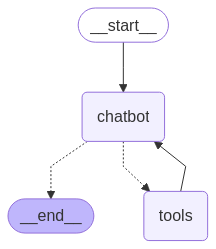

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
      user_input = input("User: ")
      if user_input.lower() in ["quit", "exit", "q"]:
          print("Goodbye!")
          break
      stream_graph_updates(user_input)

User: What’s trending in Tokyo?
Assistant: 
Assistant: {"query": "trending in Tokyo", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://timelesstokyo.com/trend", "title": "NEW & TRENDING IN TOKYO - TIMELESS TOKYO", "content": "#ACCOMMODATION\n#ACTIVITIES\n#ARCHITECTURE\n#ART\n#CRAFTSMANSHIP\n#CULTURE\n#ENTERTAINMENT\n#FASHION\n#GASTRONOMY\n#HEALTH AND WELLNESS\n#OUTDOOR\n#SHOPPING\n#TRADITION\n\nNEW & TRENDING IN TOKYO\nDiscover Tokyo’s new trend\n\nHOME\nNEW & TRENDING IN TOKYO [...] ETHICAL EXPERIENCES IN TOKYO If you're seeking a more ethical way to experience Japan, the resurgence of traditional crafts and the uptick in upcycling will catch your eye in Tokyo. Against the backdrop of a bustling metropolis, you can find locals committed to positive change around almost every corner. [...] ETHICAL EXPERIENCES IN TOKYO If you're seeking a more ethical way to experience Japan, the resurgence of traditional crafts and the uptick in upcycling will cat

#Level 3
Objective
- Equip the WeatherMind with routing logic, the ability to determine which tool to use based on the intent of a user prompt. Should it calculate? Forecast weather? Recommend a look
- Enhance the chatbot’s capabilities with conversational memory, allowing it to remember and
build on prior interactions, enabling flowing dialogue

Since Objective 1 was already achieved in level 2, I will directly go to objective 2.

In [16]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

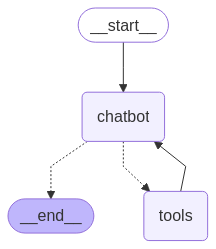

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    ):
        for value in event.values():
            print("Assistant:", value["messages"][-1].pretty_print())
while True:
      user_input = input("User: ")
      if user_input.lower() in ["quit", "exit", "q"]:
          print("Goodbye!")
          break
      stream_graph_updates(user_input)

User: hi Im Shreyansh
================================== Ai Message ==================================

Hello Shreyansh! It's nice to meet you. How can I assist you today?
Assistant: None
User: whats my name?
================================== Ai Message ==================================

Your name is Shreyansh.
Assistant: None
User: whats the weather in Delhi?
================================== Ai Message ==================================
Tool Calls:
  weather_tool (78e910d5-9356-4799-84f9-de4bc996df8c)
 Call ID: 78e910d5-9356-4799-84f9-de4bc996df8c
  Args:
    __arg1: Delhi
Assistant: None
================================= Tool Message =================================
Name: weather_tool

The current weather in Delhi is haze with a temperature of 29.05°C.
Assistant: None
================================== Ai Message ==================================

The current weather in Delhi is haze with a temperature of 29.05°C.
Assistant: None
User: what I just asked?
=======================

#Level 4
Objectives
- Define multiple agents, each with a distinct role, maybe researchers, decision-makers,
analysts, it’s up to you
- Expand or redefine the toolset and even the core application (beyond just weather/fashion)
to justify the architecture
- Implement custom routing logic between agents, ensuring they collaborate smoothly, avoid
conflict, and can fail gracefully

####Defining dummy functions for agents.

In [19]:
def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."

def book_flight(input: str):
    """Book a flight"""
    import re
    match = re.search(r"from\s+(.*?)\s+to\s+(.*)", input, re.IGNORECASE)
    from_city = match.group(1).strip().title()
    to_city = match.group(2).strip().title()
    return f"Successfully booked a flight from {from_city} to {to_city}."

flight_tool = Tool(
    name="book_flight",
    func=book_flight,
    description="Book a flight. Input is a sentence like 'book me a flight from Mumbai to Delhi'."
)

hotel_tool = Tool(
    name="book_hotel",
    func=book_hotel,
    description="Book a hotel at the hotel name given"
)

####Create Agents & Supervisor to look onto Agents.

In [26]:
flight_assistant = create_react_agent(
    model=llm,
    tools=[flight_tool],
    prompt=(
        "You are a helpful assistant that books flights."
        "Always use the `flight_tool` tool when called."
    ),
    name="flight_assistant"
)

hotel_assistant = create_react_agent(
    model=llm,
    tools=[hotel_tool],
    prompt=(
        "You are a helpful assistant that books hotels."
        "Always use the `book_hotel` tool when a user asks to book a hotel."
    ),
    name="hotel_assistant"
)

search_assistant = create_react_agent(
    model=llm,
    tools=[search_tool],
    prompt=(
        "You are a helpful assistant that searches internet."
        "Always use the `search_tool` tool."
    ),
    name="search_assistant"
)

calc_assistant = create_react_agent(
    model=llm,
    tools=[calc_tool],
    prompt=(
        "You are a helpful assistant that calculates expressions."
        "Always use the `calculator_func` tool when a user gives an arithmetic expression."
    ),
    name="calc_assistant"
)

weather_assistant = create_react_agent(
    model=llm,
    tools=[weather_tool],
    prompt=(
        "You are a helpful assistant that tells the current weather in a city."
        "Always use the `get_weather` tool when a user asks for weather."
    ),
    name="weather_assistant"
)

memory = MemorySaver()

supervisor = create_supervisor(
    agents=[
        flight_assistant,
        hotel_assistant,
        search_assistant,
        calc_assistant,
        weather_assistant,
    ],
    model=llm,
    prompt=(
        "You manage several assistants: flight booking, hotel booking, calculator, weather, and web search. "
        "Assign the user's input to the correct assistant and print what assistant gives."
    )
).compile(checkpointer=memory)

####Streaming chatbot

In [27]:
def stream_supervisor_updates(user_input: str):
    for event in supervisor.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    ):
        for value in event.values():
            print("Assistant:", value["messages"][-1].pretty_print())

while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit", "quit", "q"]:
        print("Goodbye!")
        break
    stream_supervisor_updates(user_input)

User: book a flight from delhi to kolkata
================================= Tool Message =================================
Name: transfer_to_flight_assistant

Successfully transferred to flight_assistant
Assistant: None
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
Assistant: None
================================== Ai Message ==================================
Name: supervisor

OK. I have booked a flight from Delhi to Kolkata for you.
Assistant: None
User: book the hotel radisson blu
================================= Tool Message =================================
Name: transfer_to_hotel_assistant

Successfully transferred to hotel_assistant
Assistant: None
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
Assistant: None
================================== Ai Message